# Task 3. Algorithms of unconditional nonlinear optimization. First and second order methods

### Generate random numbers $\alpha \in (0, 1)$  and $\beta \in (0, 1)$. Furthermore, generate the noisy data {$x_k, y_k$}, where $k = 0, 1, .. 100$, according to the rule: $x_k = \frac{k}{100}$, ${y_k = \alpha x_k + \beta + \delta_k}$, where $\delta_k \sim N(0, 1)$ are values of a random variable with standard normal distribution. Approximate the data by the following linear and rational functions:

### $1) F(x, a, b) = ax + b$ (linear approximant)
### $2) F(x, a, b) = \frac{a}{1 + bx}$ (rational approximant)

### by means of least squares through the numerical minimization (with precision $\varepsilon = 0.001$) of the following function:

### $D(a, b) = \sum_{k = 0}^{100} (F(x_k, a, b) - y_k)^2$

### To solve the minimization problem, use gradient descent,the conjugate gradient method, the Newton method and the Levenberg-Marquardt algorithm. If necessary, set the initial approximations and other parameters of the methods yourself. 

### On the graph (separately for each approximating function), draw an array of generateddata and graphs of approximating functions obtained using these numerical optimization algorithms. Analyzethe results obtained in terms of the number of iterations performed. Compare the results obtained with the results from previous task


In [194]:
import numpy as np
import pandas as pd
from scipy import misc
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar, minimize

global x_arr
global y_arr


def linear_approx(x, args):
    return args[0] * x + args[1]


def rational_approx(x, args):
    return args[0] / (1 + args[1] * x)


def least_squares_linear(args):
    return np.sum(np.square(args[0] * x_arr + args[1] - y_arr))


def least_squares_rational(args):
    return np.sum(np.square(args[0] / (1 + args[1] * x_arr) - y_arr))


def gradient_scipy(func, args, eps = 1e-4):
    
    a_arg, b_arg = args[0], args[1]

    part_deriv_a = misc.derivative(lambda a: func([a, b_arg]), a_arg, dx = eps)
    part_deriv_b = misc.derivative(lambda b: func([a_arg, b]), b_arg, dx = eps)

    return np.array(part_deriv_a, part_deriv_b)


def gradient_num(func, args, eps = 1e-4):
    
    '''each time the gradient is calculated, the function is evaluated for 4 times'''
    
    a_arg, b_arg = args[0], args[1]
    
    part_deriv_a = (func([a_arg + eps, b_arg]) - func([a_arg - eps, b_arg])) / (2 * eps)
    part_deriv_b = (func([a_arg, b_arg + eps]) - func([a_arg, b_arg - eps])) / (2 * eps)

    return np.array([part_deriv_a,  part_deriv_b])


def hessian_num(func, args, eps = 1e-4):
    
    '''each time the hessian is calculated, the function is evaluated for 6 times'''
    
    a_arg, b_arg = args[0], args[1]
    
    func_ab = func([a_arg, b_arg])
    func_a_eps_b = func([a_arg + eps, b_arg])
    func_a_b_eps = func([a_arg, b_arg + eps])

    part_deriv_aa = (func_a_eps_b - 2 * func_ab + func([a_arg - eps, b_arg])) / (eps ** 2)
    part_deriv_bb = (func_a_b_eps - 2 * func_ab + func([a_arg, b_arg - eps])) / (eps ** 2)
    part_deriv_ab = (func([a_arg + eps, b_arg + eps]) - func_a_eps_b - func_a_b_eps + func_ab) / (eps ** 2)
    
    return np.array([[part_deriv_aa, part_deriv_ab], [part_deriv_ab, part_deriv_bb]])


def gradient_descent(func, initial_approx = [1, 0], eps = 1e-3):
    
    func_eval_num, iter_num = 0, 0
    args_prev = np.array(initial_approx)
    grad_func_prev = gradient_num(func, args_prev)

    res = minimize_scalar(lambda x: func(args_prev - x * grad_func_prev))
    args_curr = args_prev - np.dot(grad_func_prev, res.x)
    grad_func_curr = gradient_num(func, args_curr)
    
    func_eval_num += res.nfev + 8
    iter_num += 1
    
    while np.linalg.norm(args_curr - args_prev, np.inf) >= eps:
        
        beta = np.dot(args_curr - args_prev, grad_func_curr - grad_func_prev) \
        / np.square(np.linalg.norm(grad_func_curr - grad_func_prev))
        
        args_prev = args_curr
        grad_func_prev = grad_func_curr
        
        args_curr = args_prev - np.dot(grad_func_prev, beta)
        grad_func_curr = gradient_num(func, args_curr)
        
        func_eval_num += 4
        iter_num += 1
    
    n_digits = abs(int(round(np.log10(eps))))

    return np.array([round(args_curr[0], n_digits), round(args_curr[1], n_digits), func_eval_num, iter_num])


def conjugate_gradient_descent(func, initial_approx = [1, 0], eps = 1e-3):
    
    '''
    Conjugate gradient descent method also could be realized using SciPy:
    
    res = scipy.optimize.minimize(func, initial_approx, method = 'CG', jac = (lambda x: gradient_num(func, x)), \
                   hess = (lambda x: hessian_num(func, x)), options = {'xtol': eps})             
    '''
    
    func_eval_num, iter_num = 0, 0
    args_prev = np.array(initial_approx)
    grad_func_prev = gradient_num(func, args_prev)

    res = minimize_scalar(lambda x: func(args_prev - x * grad_func_prev))
    args_curr = args_prev - np.dot(grad_func_prev, res.x)
    grad_func_curr = gradient_num(func, args_curr)
    
    conj_direction = -1 * grad_func_prev
    
    func_eval_num += res.nfev + 8
    iter_num += 1
    
    while np.linalg.norm(args_curr - args_prev, np.inf) >= eps:
        
        beta = np.dot(grad_func_curr, grad_func_curr) / np.dot(grad_func_prev, grad_func_prev)
        #beta = np.dot(grad_func_curr, grad_func_curr - grad_func_prev) / np.dot(grad_func_prev, grad_func_prev)
        
        conj_direction = np.dot(beta, conj_direction) - grad_func_curr
        
        args_prev = args_curr
        grad_func_prev = grad_func_curr

        res = minimize_scalar(lambda x: func(args_prev + x * conj_direction))
        args_curr = args_prev + np.dot(conj_direction, res.x)
        grad_func_curr = gradient_num(func, args_curr)
        
        func_eval_num += res.nfev + 4
        iter_num += 1
    
    n_digits = abs(int(round(np.log10(eps))))

    return np.array([round(args_curr[0], n_digits), round(args_curr[1], n_digits), int(func_eval_num), int(iter_num)])


def conjugate_gradient_descent_scipy(func, initial_approx = [1, 0], eps = 1e-3):
        
    res = minimize(func, initial_approx, method = 'CG', jac = (lambda x: gradient_num(func, x)), options = {'gtol': eps})             
        
    n_digits = abs(int(round(np.log10(eps))))

    return np.array([round(res.x[0], n_digits), round(res.x[1], n_digits), res.nfev, res.nit])

    
def Newton_method(func, initial_approx = [1, 0], eps = 1e-3):
    
    '''
    Newton's method also could be realized using SciPy (but it wil be more like Quasi-Newton method):
    
    res = scipy.optimize.minimize(func, initial_approx, method = 'Newton-CG', jac = (lambda x: gradient_num(func, x)), \
                   hess = (lambda x: hessian_num(func, x)), options = {'xtol': eps})              
    '''
    
    func_eval_num, iter_num = 0, 0
    args_prev = np.array(initial_approx)
    grad_func_prev = gradient_num(func, args_prev)
    hessian_func_prev = hessian_num(func, args_prev)
    
    res = minimize_scalar(lambda x: func(args_prev - x * grad_func_prev))
    beta = res.x

    args_curr = args_prev - np.dot(beta, np.dot(np.linalg.inv(hessian_func_prev), grad_func_prev))
    grad_func_curr = gradient_num(func, args_curr)
    hessian_func_curr = hessian_num(func, args_curr)

    func_eval_num += res.nfev + 20
    iter_num += 1
    
    while np.linalg.norm(args_curr - args_prev, np.inf) >= eps:
        
        beta = 0.1
        
        args_prev = args_curr
        grad_func_prev = grad_func_curr
        hessian_func_prev = hessian_func_curr
        
        args_curr = args_prev - np.dot(beta, np.dot(np.linalg.inv(hessian_func_prev), grad_func_prev))
        grad_func_curr = gradient_num(func, args_curr)
        hessian_func_curr = hessian_num(func, args_curr)
        
        func_eval_num += 10
        iter_num += 1

    n_digits = abs(int(round(np.log10(eps))))

    return np.array([round(args_curr[0], n_digits), round(args_curr[1], n_digits), func_eval_num, iter_num])


def Newton_method_scipy(func, initial_approx = [1, 0], eps = 1e-3):
    
    res = minimize(func, initial_approx, method = 'Newton-CG', jac = (lambda x: gradient_num(func, x)), \
                   hess = (lambda x: hessian_num(func, x)), options = {'xtol': eps}) 
    
    n_digits = abs(int(round(np.log10(eps))))

    return np.array([round(res.x[0], n_digits), round(res.x[1], n_digits), res.nfev, res.nit])

                   
def Levenberg_Marquardt(approx_fun, initial_approx = [1, 0], eps = 1e-3):
    
    '''minimization via Levenberg-Marquardt algorithm also could be recieved using scipy.optimize.least_squares'''
    
    reg_param = 0.01
    func_eval_num, iter_num = 0, 0
    args_prev = np.array(initial_approx)
        
    jac = np.array([gradient_num(lambda args: approx_fun(x_i, args), args_prev) for x_i in x_arr])
    inv_cond = np.linalg.inv(np.dot(jac.T, jac) + reg_param * np.diag(np.dot(jac.T, jac)) * np.eye(2))
        
    delta_arg = np.dot(inv_cond, np.dot(jac.T, y_arr - np.array([approx_fun(x_i, args_prev) for x_i in x_arr])))
    args_curr = args_prev + delta_arg
    
    func_eval_num += 4
    iter_num += 1
    
    while np.linalg.norm(args_curr - args_prev, np.inf) >= eps:
        
        args_prev = args_curr
        
        jac = np.array([gradient_num(lambda args: approx_fun(x_i, args), args_prev)for x_i in x_arr])
        inv_cond = np.linalg.inv(np.dot(jac.T, jac) + reg_param * np.diag(np.dot(jac.T, jac)) * np.eye(2))
        delta_arg = np.dot(inv_cond, np.dot(jac.T, y_arr - np.array([approx_fun(x_i, args_prev) for x_i in x_arr])))
        
        args_curr = args_prev + delta_arg
        
        func_eval_num += 4
        iter_num += 1
    
    n_digits = abs(int(round(np.log10(eps))))

    return np.array([round(args_curr[0], n_digits), round(args_curr[1], n_digits), func_eval_num, iter_num])


# TESTING ---------------------------------------------------------------------------------------

# Data from previous lab: (x_arr, y_arr) = {x_k, y_k}, k in [0, 100]:
x_arr = np.load('x_arr.npy')
y_arr = np.load('y_arr.npy')

# df_lin ans df_rat - DataFrames wirh results for linear and rational approximations from Lab 2, respectively:
df_lin = pd.read_csv('Linear_approx_lab_2.csv', index_col = 0)
df_rat = pd.read_csv('Rational_approx_lab_2.csv', index_col = 0)

# Recording the results in the same DataFrames, respectively:
algos_dict = {'gradient descent method': gradient_descent, 'conjugate gradient descent method': conjugate_gradient_descent, \
              "Quasi-Newton method": Newton_method_scipy, 'Levenberg-Marquardt alghorithm': Levenberg_Marquardt}

initial_approx = [1, 0]

for alg_name in list(algos_dict.keys())[:-1]:
    
    df_lin[alg_name] = algos_dict[alg_name](least_squares_linear, initial_approx = initial_approx)
    df_rat[alg_name] = algos_dict[alg_name](least_squares_rational, initial_approx = initial_approx)
    
alg_name = list(algos_dict.keys())[-1]
df_lin[alg_name] = algos_dict[alg_name](linear_approx, initial_approx = initial_approx)
df_rat[alg_name] = algos_dict[alg_name](rational_approx, initial_approx = initial_approx)
    
df_lin

,exhaustive search,coordinate descent method,Nelder Mead method,gradient descent method,conjugate gradient descent method,Quasi-Newton method,Levenberg-Marquardt alghorithm
a,0.451,0.452,0.451,0.451,0.451,0.451,0.451
b,0.965,0.963,0.965,0.965,0.965,0.965,0.965
nfev,4000001.000,1419.000,109.000,41.000,77.000,4.000,16.000
nit,4000001.000,132.000,59.000,7.000,3.000,3.000,4.000


In [195]:
df_rat

,exhaustive search,coordinate descent method,Nelder Mead method,gradient descent method,conjugate gradient descent method,Quasi-Newton method,Levenberg-Marquardt alghorithm
a,1.012,1.012,1.012,1.011,1.010,1.008,1.012
b,-0.285,-0.285,-0.284,-0.286,-0.287,-0.289,-0.285
nfev,4000001.000,1505.000,101.000,57.000,117.000,6.000,16.000
nit,4000001.000,100.000,56.000,7.000,4.000,5.000,4.000


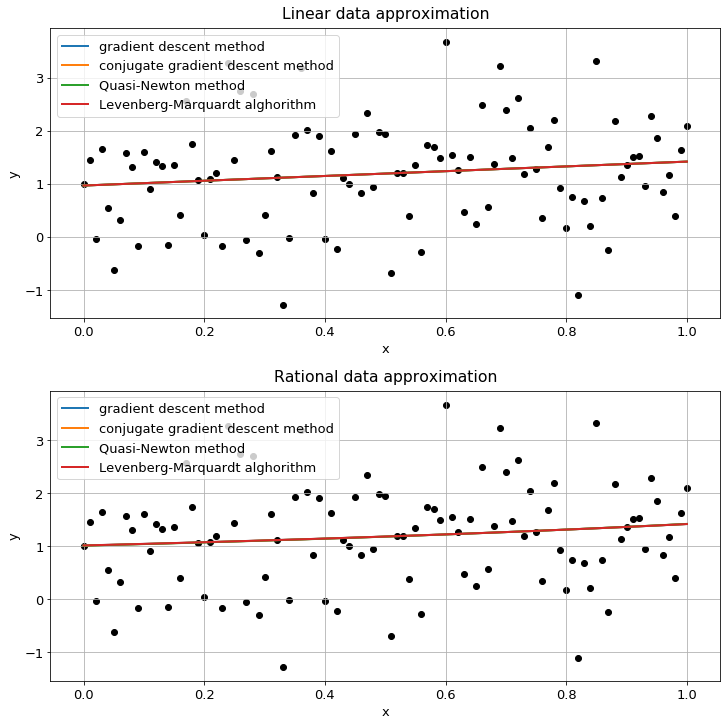

In [196]:
# Vizualization - as it should be

start_alg = 3
stop_alg = 7

fig, ax = plt.subplots(figsize = (12, 12))
plt.subplots_adjust(wspace = 0.25, hspace = 0.25)

plt.subplot(2, 1, 1)
plt.scatter(x_arr, y_arr, c = 'k')

for i in range(start_alg, stop_alg):
    
    a_lin, b_lin = round(df_lin[df_lin.columns[i]]['a'], 3), round(df_lin[df_lin.columns[i]]['b'], 3)
    plt.plot(x_arr, a_lin * x_arr + b_lin, linewidth = 2)

plt.title('Linear data approximation', pad = 10)
plt.legend(list(algos_dict.keys()), loc = 'upper left')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()


plt.subplot(2, 1, 2)
plt.scatter(x_arr, y_arr, c = 'k')

for i in range(start_alg, stop_alg):
    
    a_rat, b_rat = round(df_rat[df_rat.columns[i]]['a'], 3), round(df_rat[df_rat.columns[i]]['b'], 3)
    plt.plot(x_arr, a_rat / (1 + x_arr * b_rat), linewidth = 2)

plt.title('Rational data approximation', pad = 10)
plt.legend(list(algos_dict.keys()), loc = 'upper left')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()

plt.show()
fig.savefig('approx_result.png')

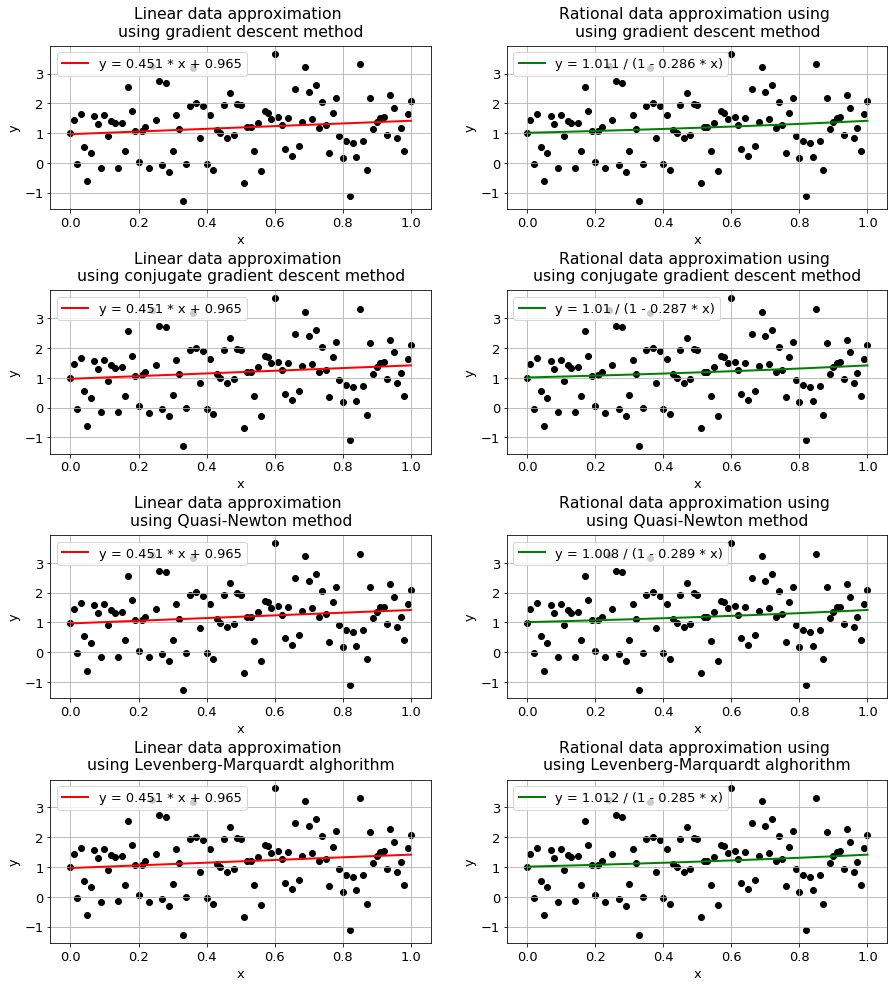

In [197]:
# Vizualization - as it should be

fig, ax = plt.subplots(figsize = (15, 30))
plt.subplots_adjust(wspace = 0.2, hspace = 0.5)

for i in range (3, 7):
    
    a_lin, b_lin = round(df_lin[df_lin.columns[i]]['a'], 3), round(df_lin[df_lin.columns[i]]['b'], 3)
    a_rat, b_rat = round(df_rat[df_rat.columns[i]]['a'], 3), round(df_rat[df_rat.columns[i]]['b'], 3)

    plt.subplot(7, 2, 2 * i + 1)
    plt.scatter(x_arr, y_arr, c = 'k')
    plt.plot(x_arr, a_lin * x_arr + b_lin, c = 'r', linewidth = 2)

    plt.title('Linear data approximation \n' + 'using ' + df_lin.columns[i], pad = 10)
    plt.legend(['y = {0} * x + {1}'.format(a_lin, b_lin)], loc = 'upper left')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid()

    plt.subplot(7, 2, 2 * i + 2)
    plt.scatter(x_arr, y_arr, c = 'k')
    plt.plot(x_arr, a_rat / (1 + x_arr * b_rat), c = 'g', linewidth = 2)

    plt.title('Rational data approximation using \n' + 'using ' + df_lin.columns[i], pad = 10)
    plt.legend(['y = {0} / (1 - {1} * x)'.format(a_rat, abs(b_rat))], loc = 'upper left')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid()

plt.show()
fig.savefig('approx_result.png')

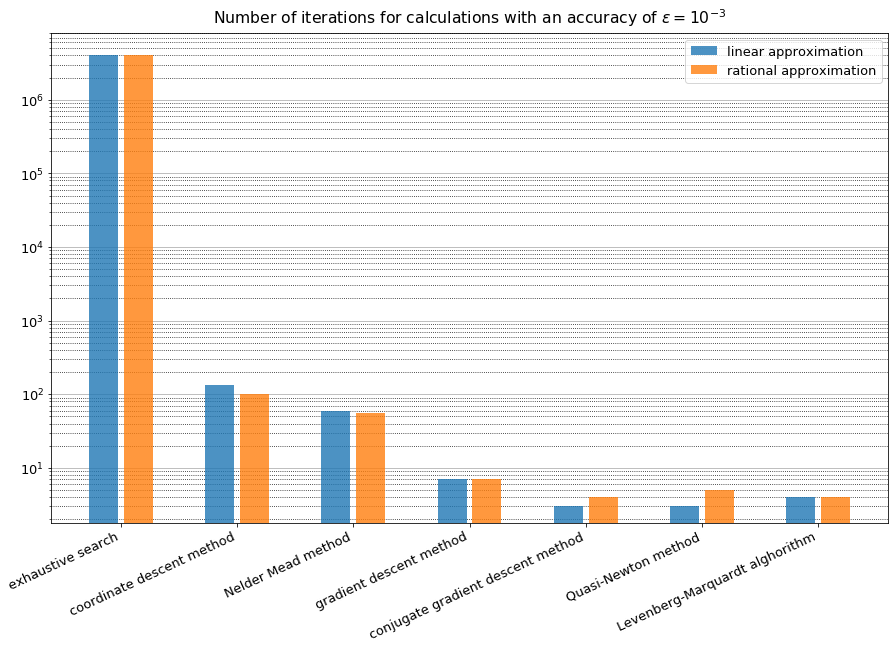

In [198]:
# Vizualization -numbers of iterations and iterations comparisson

mpl.rcParams.update({'font.size': 13})
fig = plt.figure(figsize = (15, 10))

ax = plt.axes()
ax.yaxis.grid(True, zorder = 2)
plt.title('Number of iterations for calculations with an accuracy of $\epsilon = 10^{-3}$', pad = 10)

algos_names = df_lin.columns
xs = range(len(algos_names))

plt.yscale('log')
plt.bar([x  for x in xs], [df_lin[key]['nit'] for key in algos_names], \
        width = 0.25, alpha = 0.8, label = 'linear approximation', zorder = 2)
plt.bar([x + 0.3 for x in xs], [df_rat[key]['nit'] for key in algos_names],
        width = 0.25, alpha = 0.8, label = 'rational approximation', zorder = 2)

plt.xticks([i + 0.15 for i in xs], algos_names)
plt.legend(loc = 'upper right')

ax.grid(which='minor', 
        color = 'k', 
        linestyle = ':')

fig.autofmt_xdate(rotation = 25)
fig.savefig('bars.png')

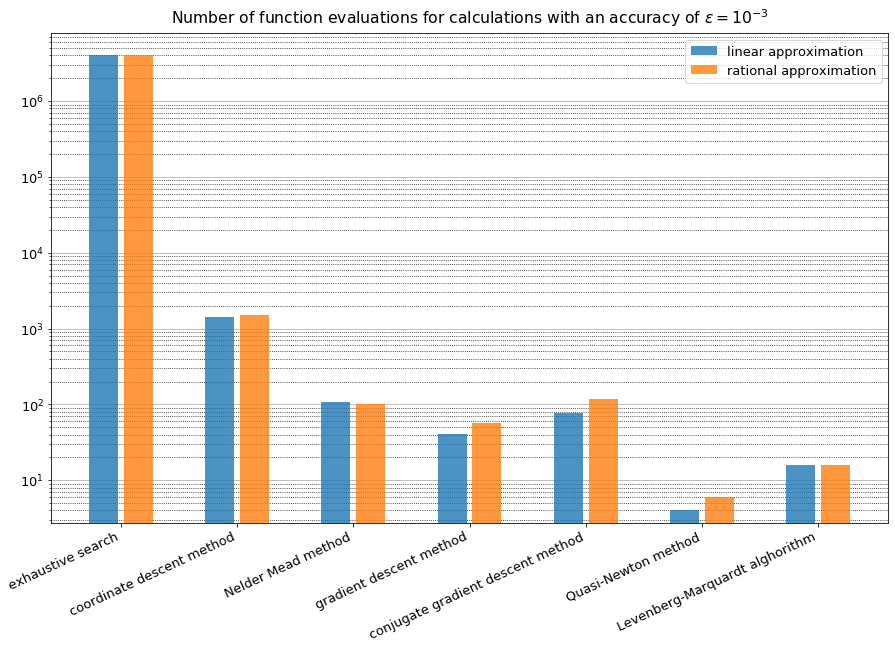

In [199]:
# Vizualization -numbers of function evaluations and iterations comparisson

mpl.rcParams.update({'font.size': 13})
fig = plt.figure(figsize = (15, 10))

ax = plt.axes()
ax.yaxis.grid(True, zorder = 2)
plt.title('Number of function evaluations for calculations with an accuracy of $\epsilon = 10^{-3}$', pad = 10)

algos_names = df_lin.columns
xs = range(len(algos_names))

plt.yscale('log')
plt.bar([x  for x in xs], [df_lin[key]['nfev'] for key in algos_names], \
        width = 0.25, alpha = 0.8, label = 'linear approximation', zorder = 2)
plt.bar([x + 0.3 for x in xs], [df_rat[key]['nfev'] for key in algos_names],
        width = 0.25, alpha = 0.8, label = 'rational approximation', zorder = 2)

plt.xticks([i + 0.15 for i in xs], algos_names)
plt.legend(loc = 'upper right')

ax.grid(which='minor', 
        color = 'k', 
        linestyle = ':')

fig.autofmt_xdate(rotation = 25)
fig.savefig('bars_2.png')

In [204]:
# precision analysis:

algos_dict = {'gradient descent method': gradient_descent, 'conjugate gradient descent method': conjugate_gradient_descent_scipy, \
              "Quasi-Newton method": Newton_method_scipy, 'Levenberg-Marquardt alghorithm': Levenberg_Marquardt}

algos_names = list(algos_dict.keys())
sol_dict = {name: {} for name in algos_names}

for alg_name in algos_names:
    sol_dict[alg_name] = {'linear': [], 'rational': []}
    
eps_arr = np.logspace(-1, -8, 100)
initial_approx = [1, 0]

for eps in eps_arr:
    
    for alg_name in algos_names[:-1]:

        lin_arr = algos_dict[alg_name](least_squares_linear, initial_approx = initial_approx, eps = eps)
        sol_dict[alg_name]['linear'].append([lin_arr[2], lin_arr[3]]) 
                                               
        rat_arr = algos_dict[alg_name](least_squares_rational,initial_approx = initial_approx, eps = eps)
        sol_dict[alg_name]['rational'].append([rat_arr[2], rat_arr[3]]) 
    
    alg_name = list(algos_dict.keys())[-1]
    
    lin_dict = algos_dict[alg_name](linear_approx, initial_approx = initial_approx)
    sol_dict[alg_name]['linear'].append([lin_arr[2], lin_arr[3]]) 

    rat_dict = algos_dict[alg_name](rational_approx, initial_approx = initial_approx)
    sol_dict[alg_name]['rational'].append([rat_arr[2], rat_arr[3]]) 
    

df = pd.DataFrame(sol_dict)
df

,gradient descent method,conjugate gradient descent method,Quasi-Newton method,Levenberg-Marquardt alghorithm
linear,"[[21.0, 2.0], [21.0, 2.0], [21.0, 2.0], [21.0,...","[[5.0, 2.0], [5.0, 2.0], [5.0, 2.0], [5.0, 2.0...","[[4.0, 3.0], [4.0, 3.0], [4.0, 3.0], [4.0, 3.0...","[[4.0, 3.0], [4.0, 3.0], [4.0, 3.0], [4.0, 3.0..."
rational,"[[37.0, 2.0], [37.0, 2.0], [37.0, 2.0], [37.0,...","[[16.0, 5.0], [16.0, 5.0], [16.0, 5.0], [16.0,...","[[3.0, 2.0], [3.0, 2.0], [3.0, 2.0], [3.0, 2.0...","[[3.0, 2.0], [3.0, 2.0], [3.0, 2.0], [3.0, 2.0..."


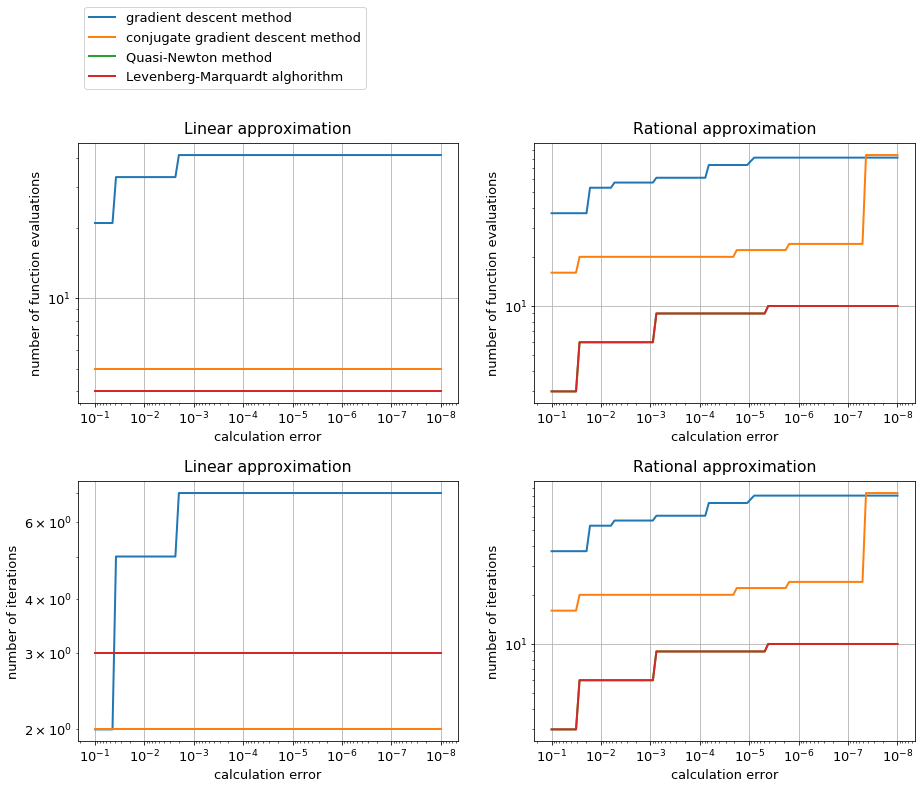

In [205]:
# Recording the results in the same DataFrames, respectively:

fig = plt.figure(figsize = (15, 11))
plt.subplots_adjust(wspace = 0.2, hspace = 0.3)


plt.subplot(2, 2, 1)
plt.xscale('log')
plt.yscale('log')
plt.title('Linear approximation', pad = 10)
#plt.title('Number of function evaluation depending on \n accuracy for linear approximation', pad = 10)

for alg_name in algos_names:
    
    y_data = [sol_dict[alg_name]['linear'][i][0] for i in range(len(sol_dict[alg_name]['linear']))]
    plt.plot(eps_arr[:len(y_data)], y_data, linewidth = 2)
        
#plt.legend(algos_names, loc = 'best')
plt.xlabel('calculation error')
plt.ylabel('number of function evaluations')
plt.grid()

ax = plt.gca()
ax.invert_xaxis()


plt.subplot(2, 2, 2)
plt.xscale('log')
plt.yscale('log')
plt.title('Rational approximation', pad = 10)
#plt.title('Number of function evaluation depending on \n accuracy for rational approximation', pad = 10)

for alg_name in algos_names:
    
    y_data = [sol_dict[alg_name]['rational'][i][0] for i in range(len(sol_dict[alg_name]['rational']))]
    plt.plot(eps_arr[:len(y_data)], y_data, linewidth = 2)
    
#plt.legend(algos_names, loc = 'best')
plt.xlabel('calculation error')
plt.ylabel('number of function evaluations')
plt.grid()

ax = plt.gca()
ax.invert_xaxis()


plt.subplot(2, 2, 3)
plt.xscale('log')
plt.yscale('log')
plt.title('Linear approximation', pad = 10)
#plt.title('Number of iterations depending on \n accuracy for linear approximation', pad = 10)

for alg_name in algos_names:
    
    y_data = [sol_dict[alg_name]['linear'][i][1] for i in range(len(sol_dict[alg_name]['linear']))]
    plt.plot(eps_arr[:len(y_data)], y_data, linewidth = 2)
        
#plt.legend(algos_names, loc = 'lower right')
plt.xlabel('calculation error')
plt.ylabel('number of iterations')
plt.grid()

ax = plt.gca()
ax.invert_xaxis()


plt.subplot(2, 2, 4)
plt.xscale('log')
plt.yscale('log')
plt.title('Rational approximation', pad = 10)
#plt.title('Number of iterations depending on \n accuracy for rational approximation', pad = 10)

for alg_name in algos_names:
    
    y_data = [sol_dict[alg_name]['rational'][i][0] for i in range(len(sol_dict[alg_name]['rational']))]
    plt.plot(eps_arr[:len(y_data)], y_data, linewidth = 2)
    
#plt.legend(algos_names, loc = 'lower right')
plt.legend(algos_names, bbox_to_anchor=(-1.2, 2.85), loc = "upper left")
plt.xlabel('calculation error')
plt.ylabel('number of iterations')
plt.grid()

ax = plt.gca()
ax.invert_xaxis()